# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [340]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pytesseract
import shutil
import random
from matplotlib import pyplot as plt
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [341]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [342]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [343]:
# What model to download.
MODEL_NAME = 'Digital_Incentives-9429'


# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'object-detection.pbtxt')

## Download Model

## Load a (frozen) Tensorflow model into memory.

In [344]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [345]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [346]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [347]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(0, 1)]
# TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(3, 8) ]
# TEST_IMAGE_PATHS = ["D:\\Osmosis-2020\\Main\\Application\\WebApp\\WebApp\\UploadedFiles\\image{}.jpg".format(i)]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [348]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [349]:
def export_images(notebook_filepath,
                  output_directory):
    notebook_image_exporter = NotebookImageExporter(notebook_filepath,
                                                    output_directory)
    notebook_image_exporter.save_images()

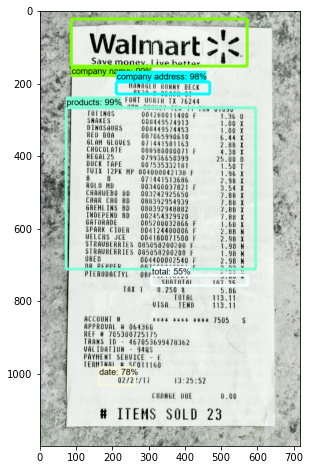

In [366]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)

  # getting product from image
  #products[] = output_dict
  output_company_name={}
  output_company_name['detection_scores']=0.0
  output_company_address={}
  output_company_address['detection_scores']=0.0
  output_products={}
  output_products['detection_scores']=0.0
  output_total={}
  output_total['detection_scores']=0.0
  output_date={}
  output_date['detection_scores']=0.0
  f=[0,0,0,0,0]
  for i in range(0, output_dict['num_detections']):
        if output_dict['detection_classes'][i]== 1 :
            if f[0]!=1:
                output_company_name['detection_scores']=output_dict['detection_scores'][i]
                f[0]=1
            if output_company_name['detection_scores']>output_dict['detection_scores'][i]:
                output_dict['detection_scores'][i]=0.0
        elif output_dict['detection_classes'][i]== 2 :
            if f[1]!=1:
                output_company_address['detection_scores']=output_dict['detection_scores'][i]
                f[1]=1
            if output_company_address['detection_scores']>output_dict['detection_scores'][i]:
                output_dict['detection_scores'][i]=0.0
        elif output_dict['detection_classes'][i]== 3 :
            if f[2]!=1:
                output_products['detection_scores']=output_dict['detection_scores'][i]
                f[2]=1
            if output_products['detection_scores']>output_dict['detection_scores'][i]:
                output_dict['detection_scores'][i]=0.0
        elif output_dict['detection_classes'][i]== 4 :
            if f[3]!=1:
                output_total['detection_scores']=output_dict['detection_scores'][i]
                f[3]=1
            if output_total['detection_scores']>output_dict['detection_scores'][i]:
                output_dict['detection_scores'][i]=0.0
        elif output_dict['detection_classes'][i]== 5 :
            if f[4]!=1:
                output_date['detection_scores']=output_dict['detection_scores'][i]
                f[4]=1
            if output_date['detection_scores']>output_dict['detection_scores'][i]:
                output_dict['detection_scores'][i]=0.0
  SAVEIMAGES_PATH = "D:\\Osmosis-2020\\Main\\Application\\WebApp\\WebApp\\ProcessedFiles\\"
  image.save(SAVEIMAGES_PATH + "originalImage.jpg")
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      min_score_thresh=0.5,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  plt.savefig(SAVEIMAGES_PATH + "segmentedImage.jpg")
  plt.savefig(SAVEIMAGES_PATH + "segmentedImageTight.jpg", bbox_inches='tight')
    

In [351]:
validDetection=0
validBox={}
validClass=[]
for i in range(0,output_dict['num_detections']):
    if(output_dict['detection_scores'][i]>0.5):
        print(output_dict['detection_boxes'][i])
        validBox[validDetection] = output_dict['detection_boxes'][i]
        validClass.append(output_dict['detection_classes'][i])
        validDetection= validDetection+1
        

[0.22290657 0.09945574 0.5932016  0.8262883 ]
[0.01859987 0.11900948 0.12635186 0.7943145 ]
[0.16344367 0.29193866 0.19059001 0.6517544 ]
[0.83908504 0.22438696 0.85944366 0.3640159 ]
[0.6077495  0.42680788 0.6307399  0.796026  ]


In [352]:
print(validBox)
print(validClass)
print("--------------------------------------------------")
print(validBox[0][0]*1000)

{0: array([0.22290657, 0.09945574, 0.5932016 , 0.8262883 ], dtype=float32), 1: array([0.01859987, 0.11900948, 0.12635186, 0.7943145 ], dtype=float32), 2: array([0.16344367, 0.29193866, 0.19059001, 0.6517544 ], dtype=float32), 3: array([0.83908504, 0.22438696, 0.85944366, 0.3640159 ], dtype=float32), 4: array([0.6077495 , 0.42680788, 0.6307399 , 0.796026  ], dtype=float32)}
[3, 1, 2, 5, 4]
--------------------------------------------------
222.90657460689545


In [353]:
pytesseract.pytesseract.tesseract_cmd = "C:\\Program Files\\Tesseract-OCR\\tesseract.exe"                                                                     

[0.22290657 0.09945574 0.5932016  0.8262883 ]
products - extracted words - ee eee.) eee eea ae wi
(OT LHOS 604260011400 FSHAKES. 000449574913
DINOSAURS 000449574453
RED BOA 607065990610
GLAM GLOVES 0671441501163
CHOCOLATE 000580000071 F
REGAL 25 079936650399
DUCK TAPE 607535332181
TWIX 2PK MP 004000042198 F
8 6 071441519686
ROLO ND 003400037821 F
CHARWEBO BD 0032429725650
CHAR CHO BD 068392954939
GREHLINS BD 080397948882
INDEPEND BD 002454329920
GATORADE 005200052866 F
SPARK CIDER 004124400006 F
WELCHS JCE 004166071500 F
STRAWBERRIES 085058200200 F
STRAWBERRIES 085058200200 F
OREO 004400002540 F
DR PEPPER novannnne7at2Me Be ee He SE Oe EK OE KE KO EE EOE end
--------------------------------------------------------------------------------
[0.01859987 0.11900948 0.12635186 0.7943145 ]
company name - extracted words - _ 8
- Walmart tcSave money. Live better. end
--------------------------------------------------------------------------------
[0.16344367 0.29193866 0.19059001 0.6517544 ]
c

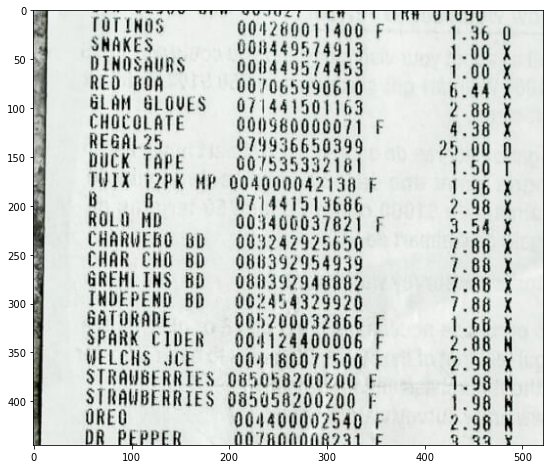

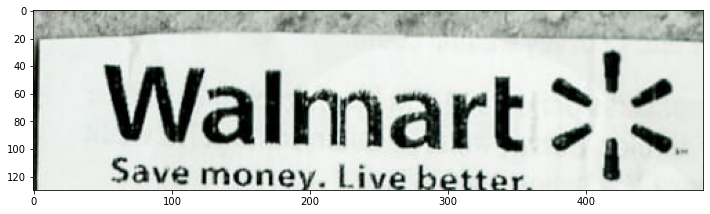

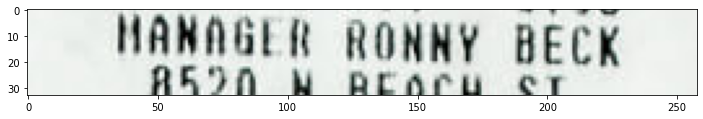

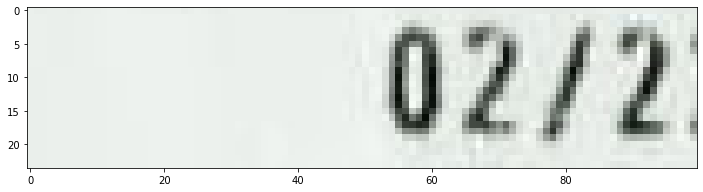

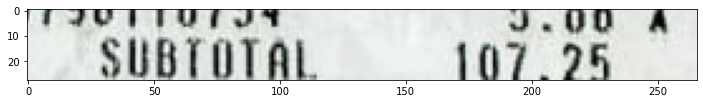

In [361]:
image = Image.open(TEST_IMAGE_PATHS[0])
#print(validDetection)
objclass=['nthg','company name','company address','products','total','date','nthg-2']
width, height = image.size
for i in range(0,validDetection):
    print(validBox[i])
    img = image
    y1=(validBox[i][0]*height)
    x1=(validBox[i][1]*width)
    y2=validBox[i][2]*height
    x2=(validBox[i][3]*width)
    crop = image.crop((x1, y1 , x2, y2))
    #crop = img.crop((x1, y1 , x2, y2))
    #img = cv2.imread(crop,cv2.IMREAD_GRAYSCALE)
    extracted_text = pytesseract.image_to_string(crop, lang = 'eng')
    #crop = image.crop((220.33158, 127.5349 , 632.36636, 837.6518))
    
    SAVEIMAGES_PATH = "D:\\Osmosis-2020\\Main\\Application\\WebApp\\WebApp\\ProcessedFiles\\"
    if(objclass[validClass[i]] == "company name"):
        crop.save(SAVEIMAGES_PATH + "companyName.jpg")
        f= open(SAVEIMAGES_PATH + "companyName.txt","w+")
        f.write(extracted_text.lstrip().replace("\n\n", ""))
        f.close()
    elif(objclass[validClass[i]] == "company address"):
        crop.save(SAVEIMAGES_PATH + "companyAddress.jpg")
        f= open(SAVEIMAGES_PATH + "companyAddress.txt","w+")
        f.write(extracted_text.lstrip().replace("\n\n", ""))
        f.close()
    elif(objclass[validClass[i]] == "products"):
        crop.save(SAVEIMAGES_PATH + "products.jpg")
        f= open(SAVEIMAGES_PATH + "products.txt","w+")
        f.write(extracted_text.lstrip().replace("\n\n", ""))
        f.close()
    elif(objclass[validClass[i]] == "total"):
        crop.save(SAVEIMAGES_PATH + "total.jpg")
        f= open(SAVEIMAGES_PATH + "total.txt","w+")
        f.write(extracted_text.lstrip().replace("\n\n", ""))
        f.close()
    elif(objclass[validClass[i]] == "date"):
        crop.save(SAVEIMAGES_PATH + "date.jpg")
        f= open(SAVEIMAGES_PATH + "date.txt","w+")
        f.write(extracted_text.lstrip().replace("\n\n", ""))
        f.close()
    print(objclass[validClass[i]]+" - extracted words - "+extracted_text.lstrip().replace("\n\n", "")+" end")
    print("--------------------------------------------------------------------------------")
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(crop)
    